C:\Users\Daniel\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



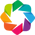

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ochl
import ccxt
import datetime
import holoviews as hv
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')
import requests
from sqlalchemy import create_engine
import matplotlib.ticker as ticker

In [2]:
import requests
import time

def get_ochlw(symbol,start=None,end=None,limit=100):
    '''
    start e end sao timestamps em milisegundos
    limit e entre 1 e 1000
    retorna uma dupla com booleano se deu certo e uma lista
    '''
    url='https://api.bitfinex.com/v2/candles/trade:5m:' + symbol + '/hist?sort=1&limit=' + str(limit)
    if(start!=None):
        url=url+'&start='+str(start)
    if(end!=None):
        url=url+'&end='+str(end)
    pagina=requests.get(url)
    texto=pagina.text
    lista=eval(texto)
    if len(lista)==0:
        return True,[]
    if lista[0]=='error':
        time.sleep(20)
        return False,[]
    return True,lista

def get_ochlwsuper(symbol,start,end=None):
    '''
    Funcao devolve todos ou valores ochl entre start e end em milisegundos
    '''
    flag=False
    ochl=[]
    while(not flag):
        flag,lista=get_ochlw(symbol,start,end,1000)
    tam=len(lista)
    while(tam!=0):
        ochl=ochl+lista
        start=lista[-1][0]+1
        while(not flag):
            flag,lista=get_ochlw(symbol,start,end,1000)
        flag=False
        tam=len(lista)
    return ochl

In [3]:
#Obtenca dos ultimos 360 dias de BTC/USD
end = datetime.datetime.now()
start = end - datetime.timedelta(days=360)
startapi=int(start.timestamp()*1000)
endapi=int(end.timestamp()*1000)
#Foi multiplicado por 1000 e transformado em int porque a entrada da funcao em milisegundos e inteiro

btcusd=get_ochlwsuper('tBTCUSD',startapi,endapi)

In [4]:
databtc=pd.DataFrame(btcusd,columns=['Date','Open','Close','High','Low','Volume'])
databtc=databtc.drop_duplicates(subset=['Date'])
databtc['Date']=pd.to_datetime(databtc['Date']*1000000)

In [6]:
#Obtenca dos ultimos 360 dias de ETH/USD
end = datetime.datetime.now()
start = end - datetime.timedelta(days=360)
startapi=int(start.timestamp()*1000)
endapi=int(end.timestamp()*1000)
#Foi multiplicado por 1000 e transformado em int porque a entrada da funcao em milisegundos e inteiro

ethusd=get_ochlwsuper('tETHUSD',startapi,endapi)

In [7]:
dataeth=pd.DataFrame(ethusd,columns=['Date','Open','Close','High','Low','Volume'])
dataeth=dataeth.drop_duplicates(subset=['Date'])
dataeth['Date']=pd.to_datetime(dataeth['Date']*1000000)

In [8]:
conex=create_engine('sqlite:///Trabalho.sqlite')
databtc.to_sql('BTCUSD',conex)
dataeth.to_sql('ETHUSD',conex)

In [151]:
databtc=pd.read_sql_query('select * from BTCUSD',conex)
dataeth=pd.read_sql_query('select * from ETHUSD',conex)

In [152]:
databtc['Date']=pd.to_datetime(databtc.Date)
dataeth['Date']=pd.to_datetime(dataeth.Date)

In [153]:
def load_symbol(symbol,y, **kwargs):
    df = data[symbol]
    return hv.Curve(df, ('Date', 'Date'), (str(y), str(y)))

stock_symbols = ['ETH', 'BTC','']
data = {"ETH": dataeth, 'BTC':databtc}
dmap = hv.DynamicMap(load_symbol, kdims=['Symbol','OHCL']).redim.values(Symbol=stock_symbols,OHCL=['Open','Close','High','Low','Volume'])

In [154]:
%%opts Curve [width=700] {+framewise}
dmap

:DynamicMap   [Symbol,OHCL]

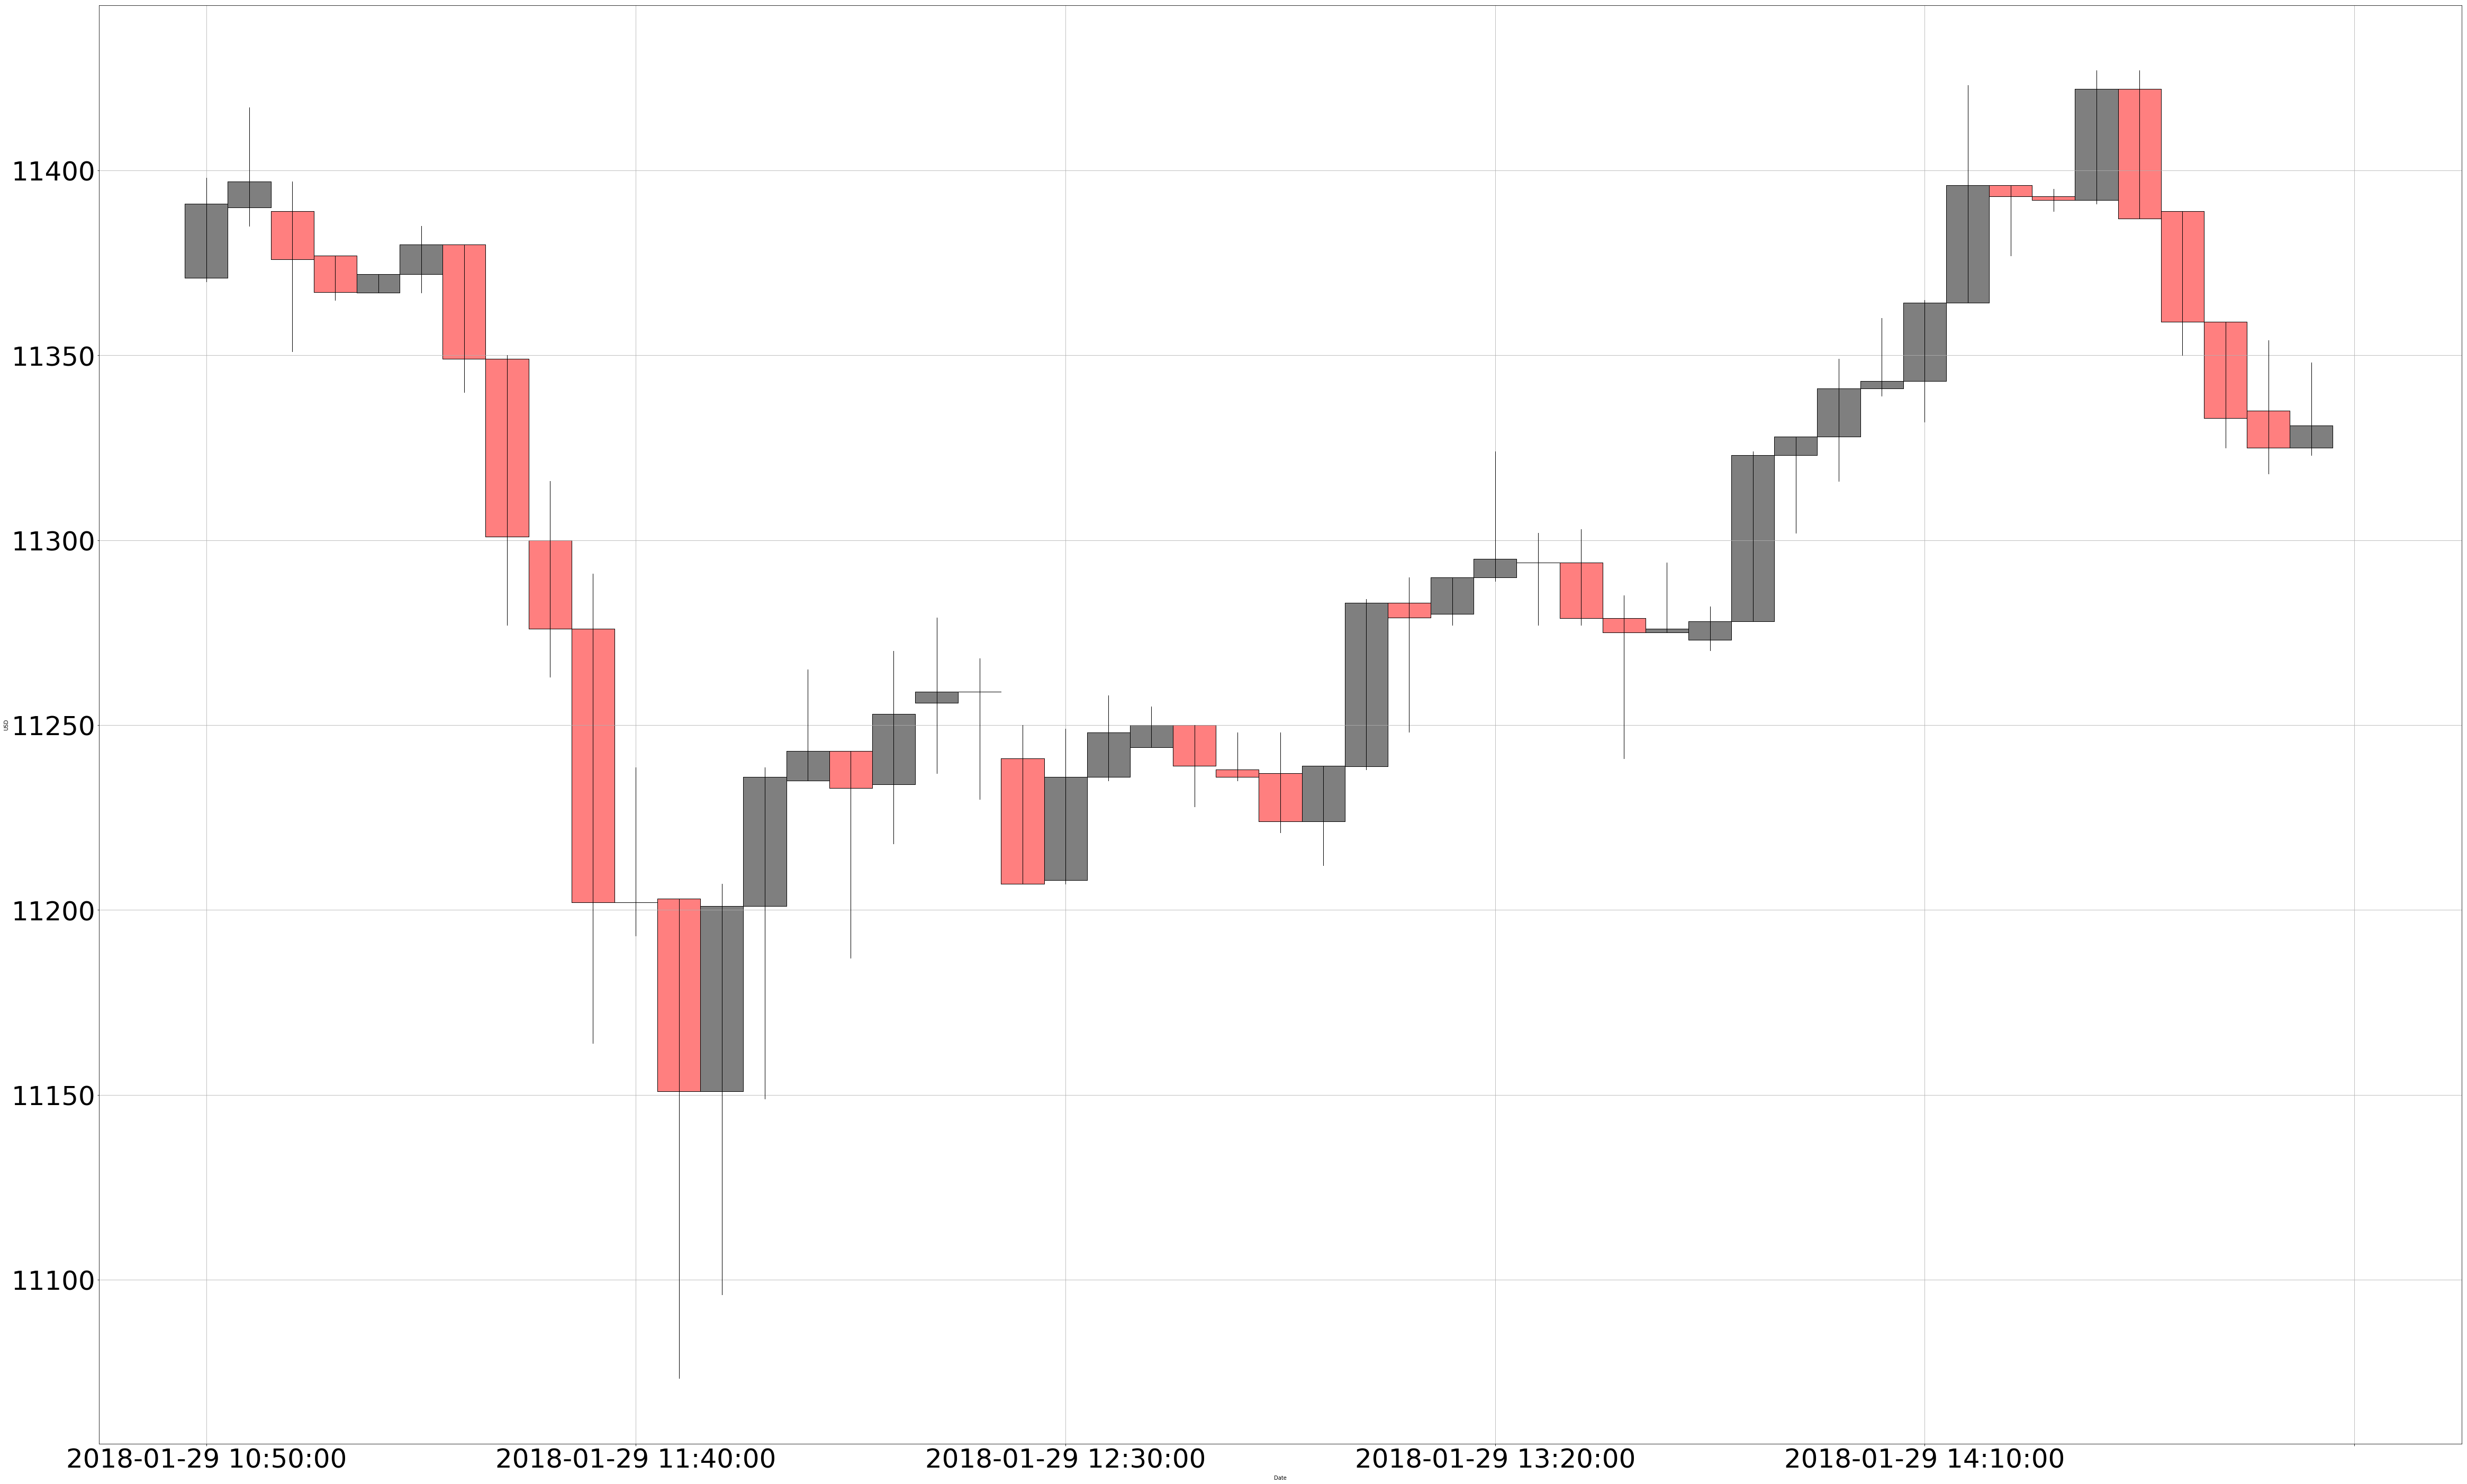

In [163]:
databtc=databtc.set_index('Date')

fig, ax = plt.subplots()
#codigo retirado de https://stackoverflow.com/questions/36334665/how-to-plot-ohlc-candlestick-with-datetime-in-matplotlib
ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
def mydate(x,pos):
    try:
        return databtc.index[-50:][int(x)]
    except IndexError:
        return ''
ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
#fim do codigo copiado
ax.set_xlabel('Date')
ax.set_ylabel('USD')
matplotlib.rc('xtick', labelsize=50) 
matplotlib.rc('ytick', labelsize=50) 
plt.rcParams["figure.figsize"] = [80,50]
plt.grid()
candlestick2_ochl(ax,databtc['Open'][-50:], databtc['Close'][-50:], databtc['High'][-50:], databtc['Low'][-50:], width=1, colorup='k', colordown='r', alpha=.50)
plt.show()

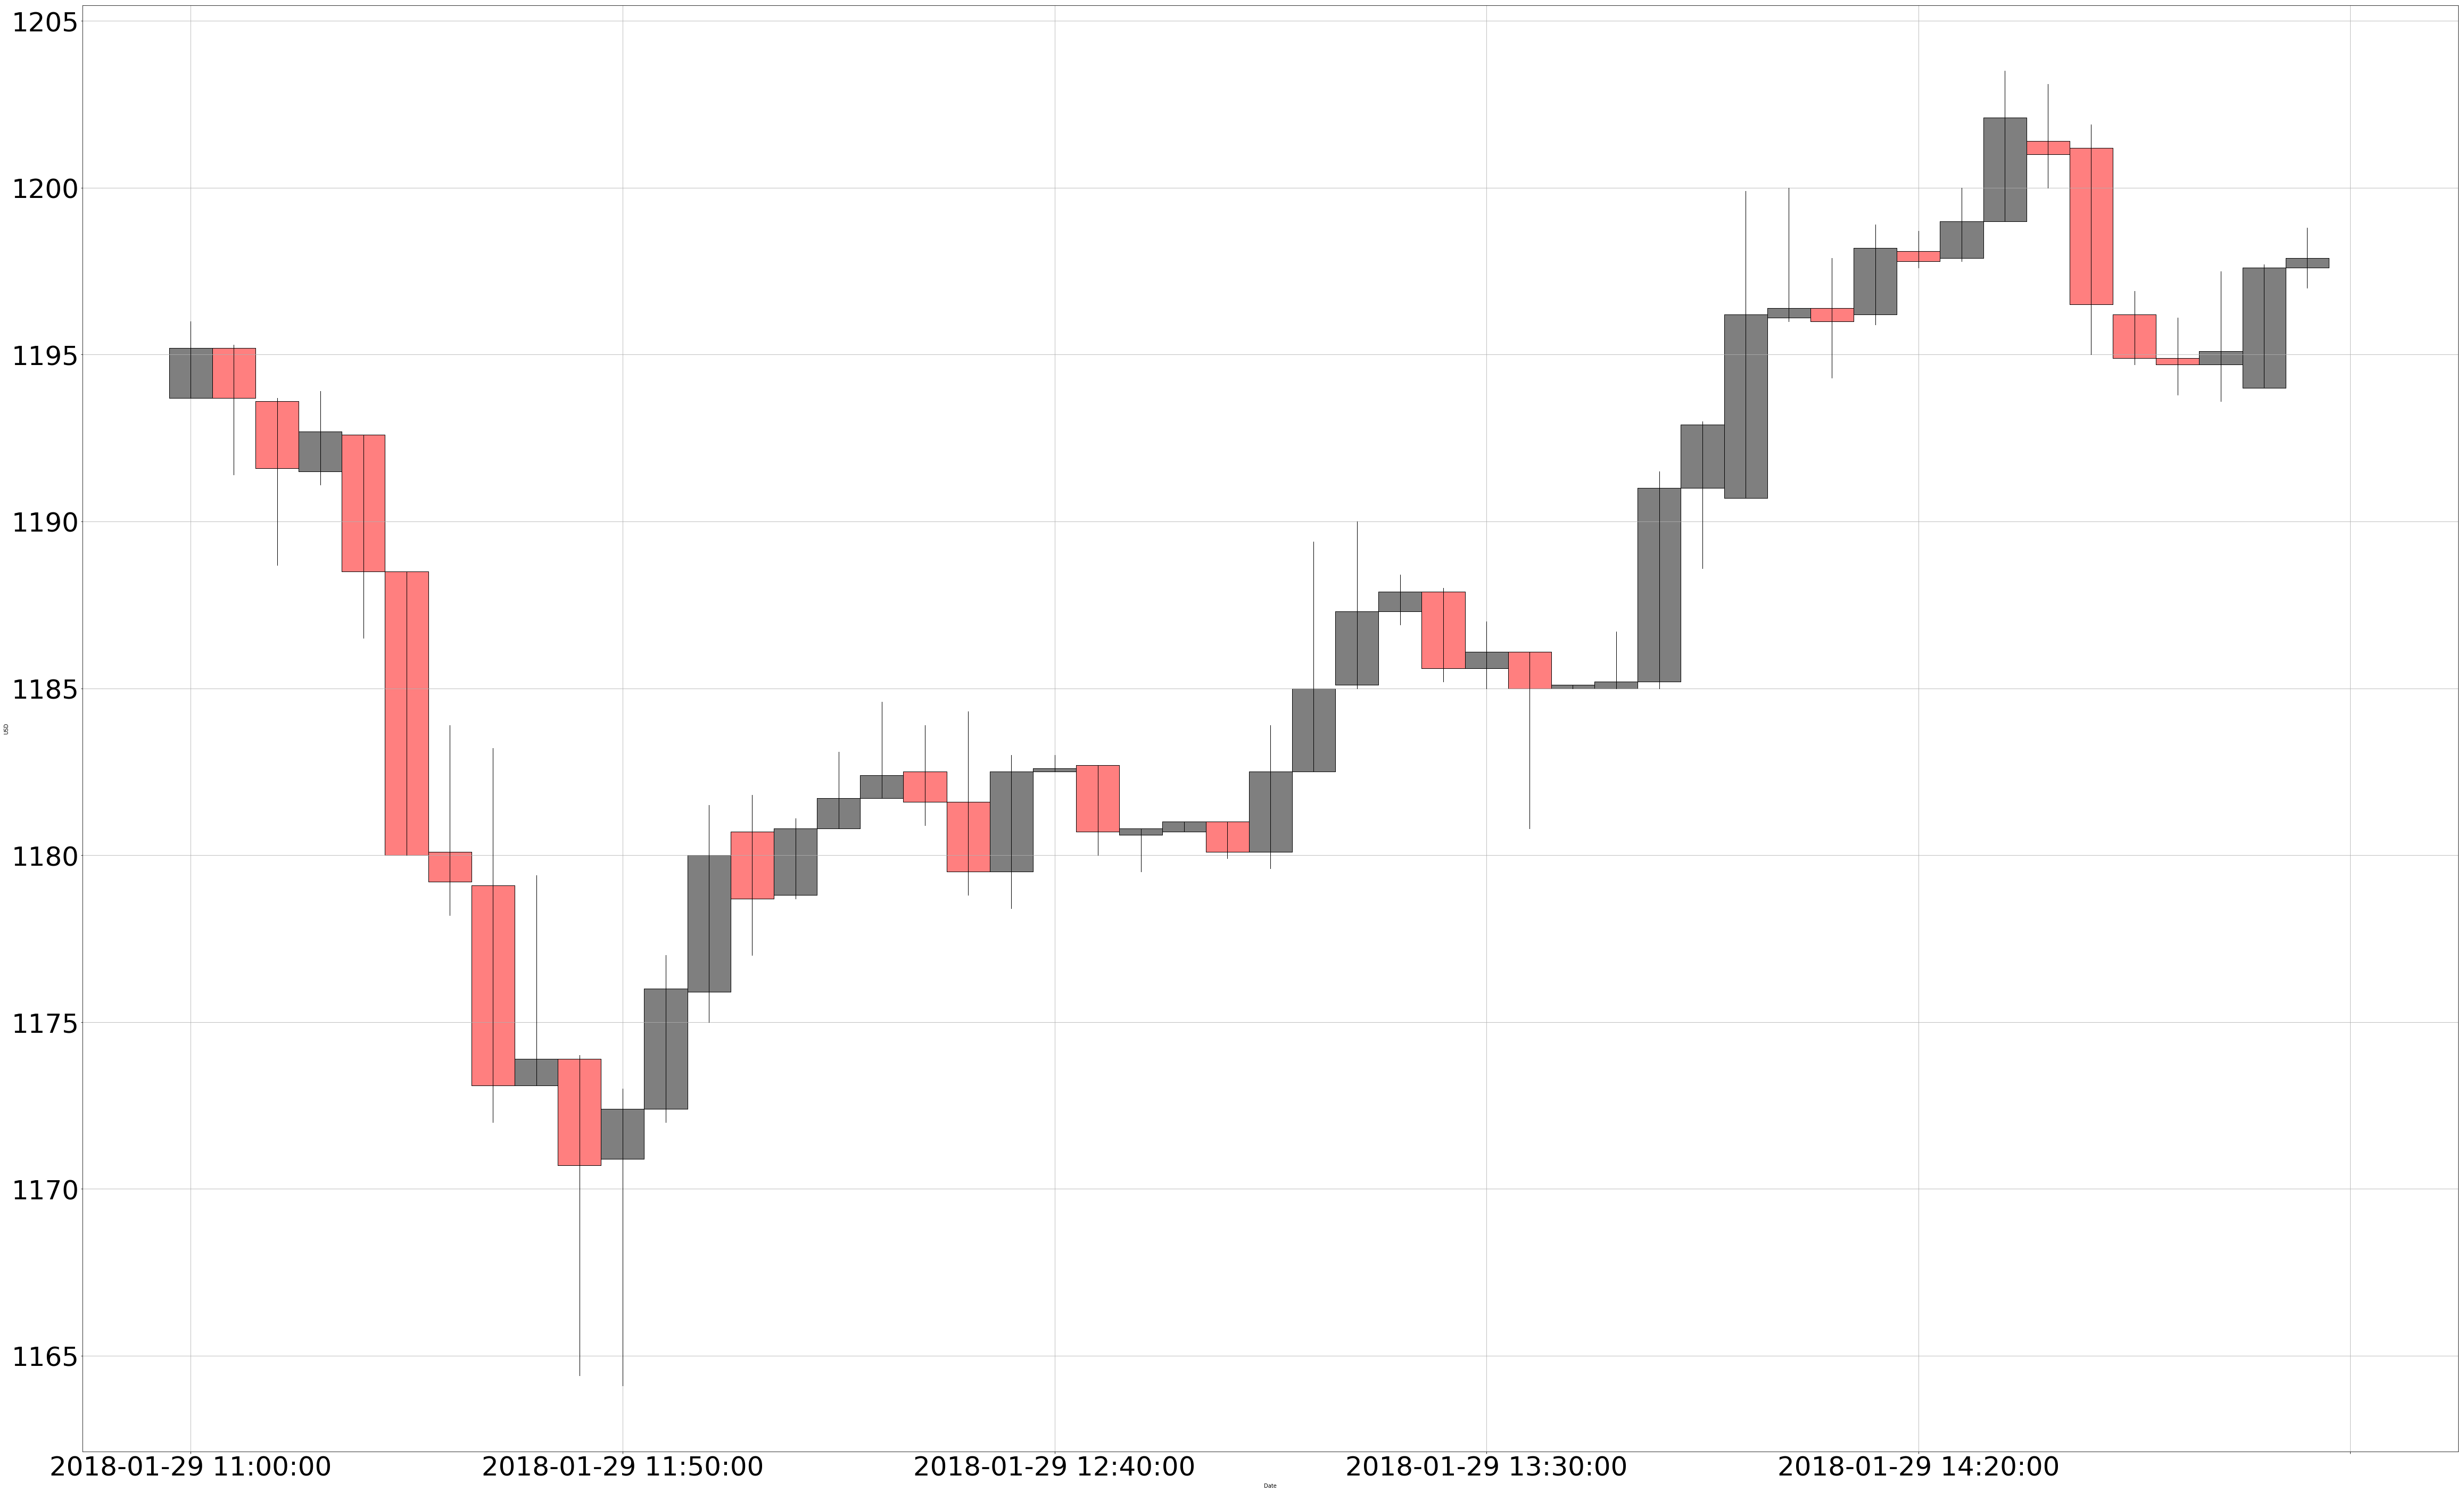

In [164]:
dataeth=dataeth.set_index('Date')
fig, ax = plt.subplots()
#codigo retirado de https://stackoverflow.com/questions/36334665/how-to-plot-ohlc-candlestick-with-datetime-in-matplotlib
ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
def mydate(x,pos):
    try:
        return dataeth.index[-50:][int(x)]
    except IndexError:
        return ''
ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
#fim do codigo copiado
ax.set_xlabel('Date')
ax.set_ylabel('USD')
matplotlib.rc('xtick', labelsize=50) 
matplotlib.rc('ytick', labelsize=50) 
plt.rcParams["figure.figsize"] = [80,50]
plt.grid()
candlestick2_ochl(ax,dataeth['Open'][-50:], dataeth['Close'][-50:], dataeth['High'][-50:], dataeth['Low'][-50:], width=1, colorup='k', colordown='r', alpha=.50)
plt.show()

In [165]:
dataeth['5m_return1'] = dataeth.Close/dataeth.Close.shift(1) - 1
databtc['5m_return'] = databtc.Close/databtc.Close.shift(1) - 1

In [201]:
%%opts Overlay [width=900 height=500 legend_position='bottom_left'] Curve(muted_alpha=0.9, muted_color='black')
databtc=databtc.reset_index()
dataeth=dataeth.reset_index()
hv.Curve(databtc[-200:], ('Date', 'Date'), ('5m_return', '5m_return'),label='BTC/USD') *\
hv.Curve(dataeth[-200:], ('Date', 'Date'), ('5m_return1', '5m_return'),label='ETH/USD')

:Overlay
   .Curve.BTC_over_USD :Curve   [Date]   (5m_return)
   .Curve.ETH_over_USD :Curve   [Date]   (5m_return1)

In [202]:
databtc=databtc.set_index('Date')
dataeth=dataeth.set_index('Date')
dataframe=databtc.combine_first(dataeth)
dataframe['fraction']=dataframe['5m_return']/dataframe['5m_return1']

In [203]:
%%opts Scatter [width=900 height=500 show_grid=True]
dataframe=dataframe.reset_index()
hv.Scatter(dataframe[-200:],('Date','Date'),('fraction','Relation between the Returns'))

:Scatter   [Date]   (fraction)

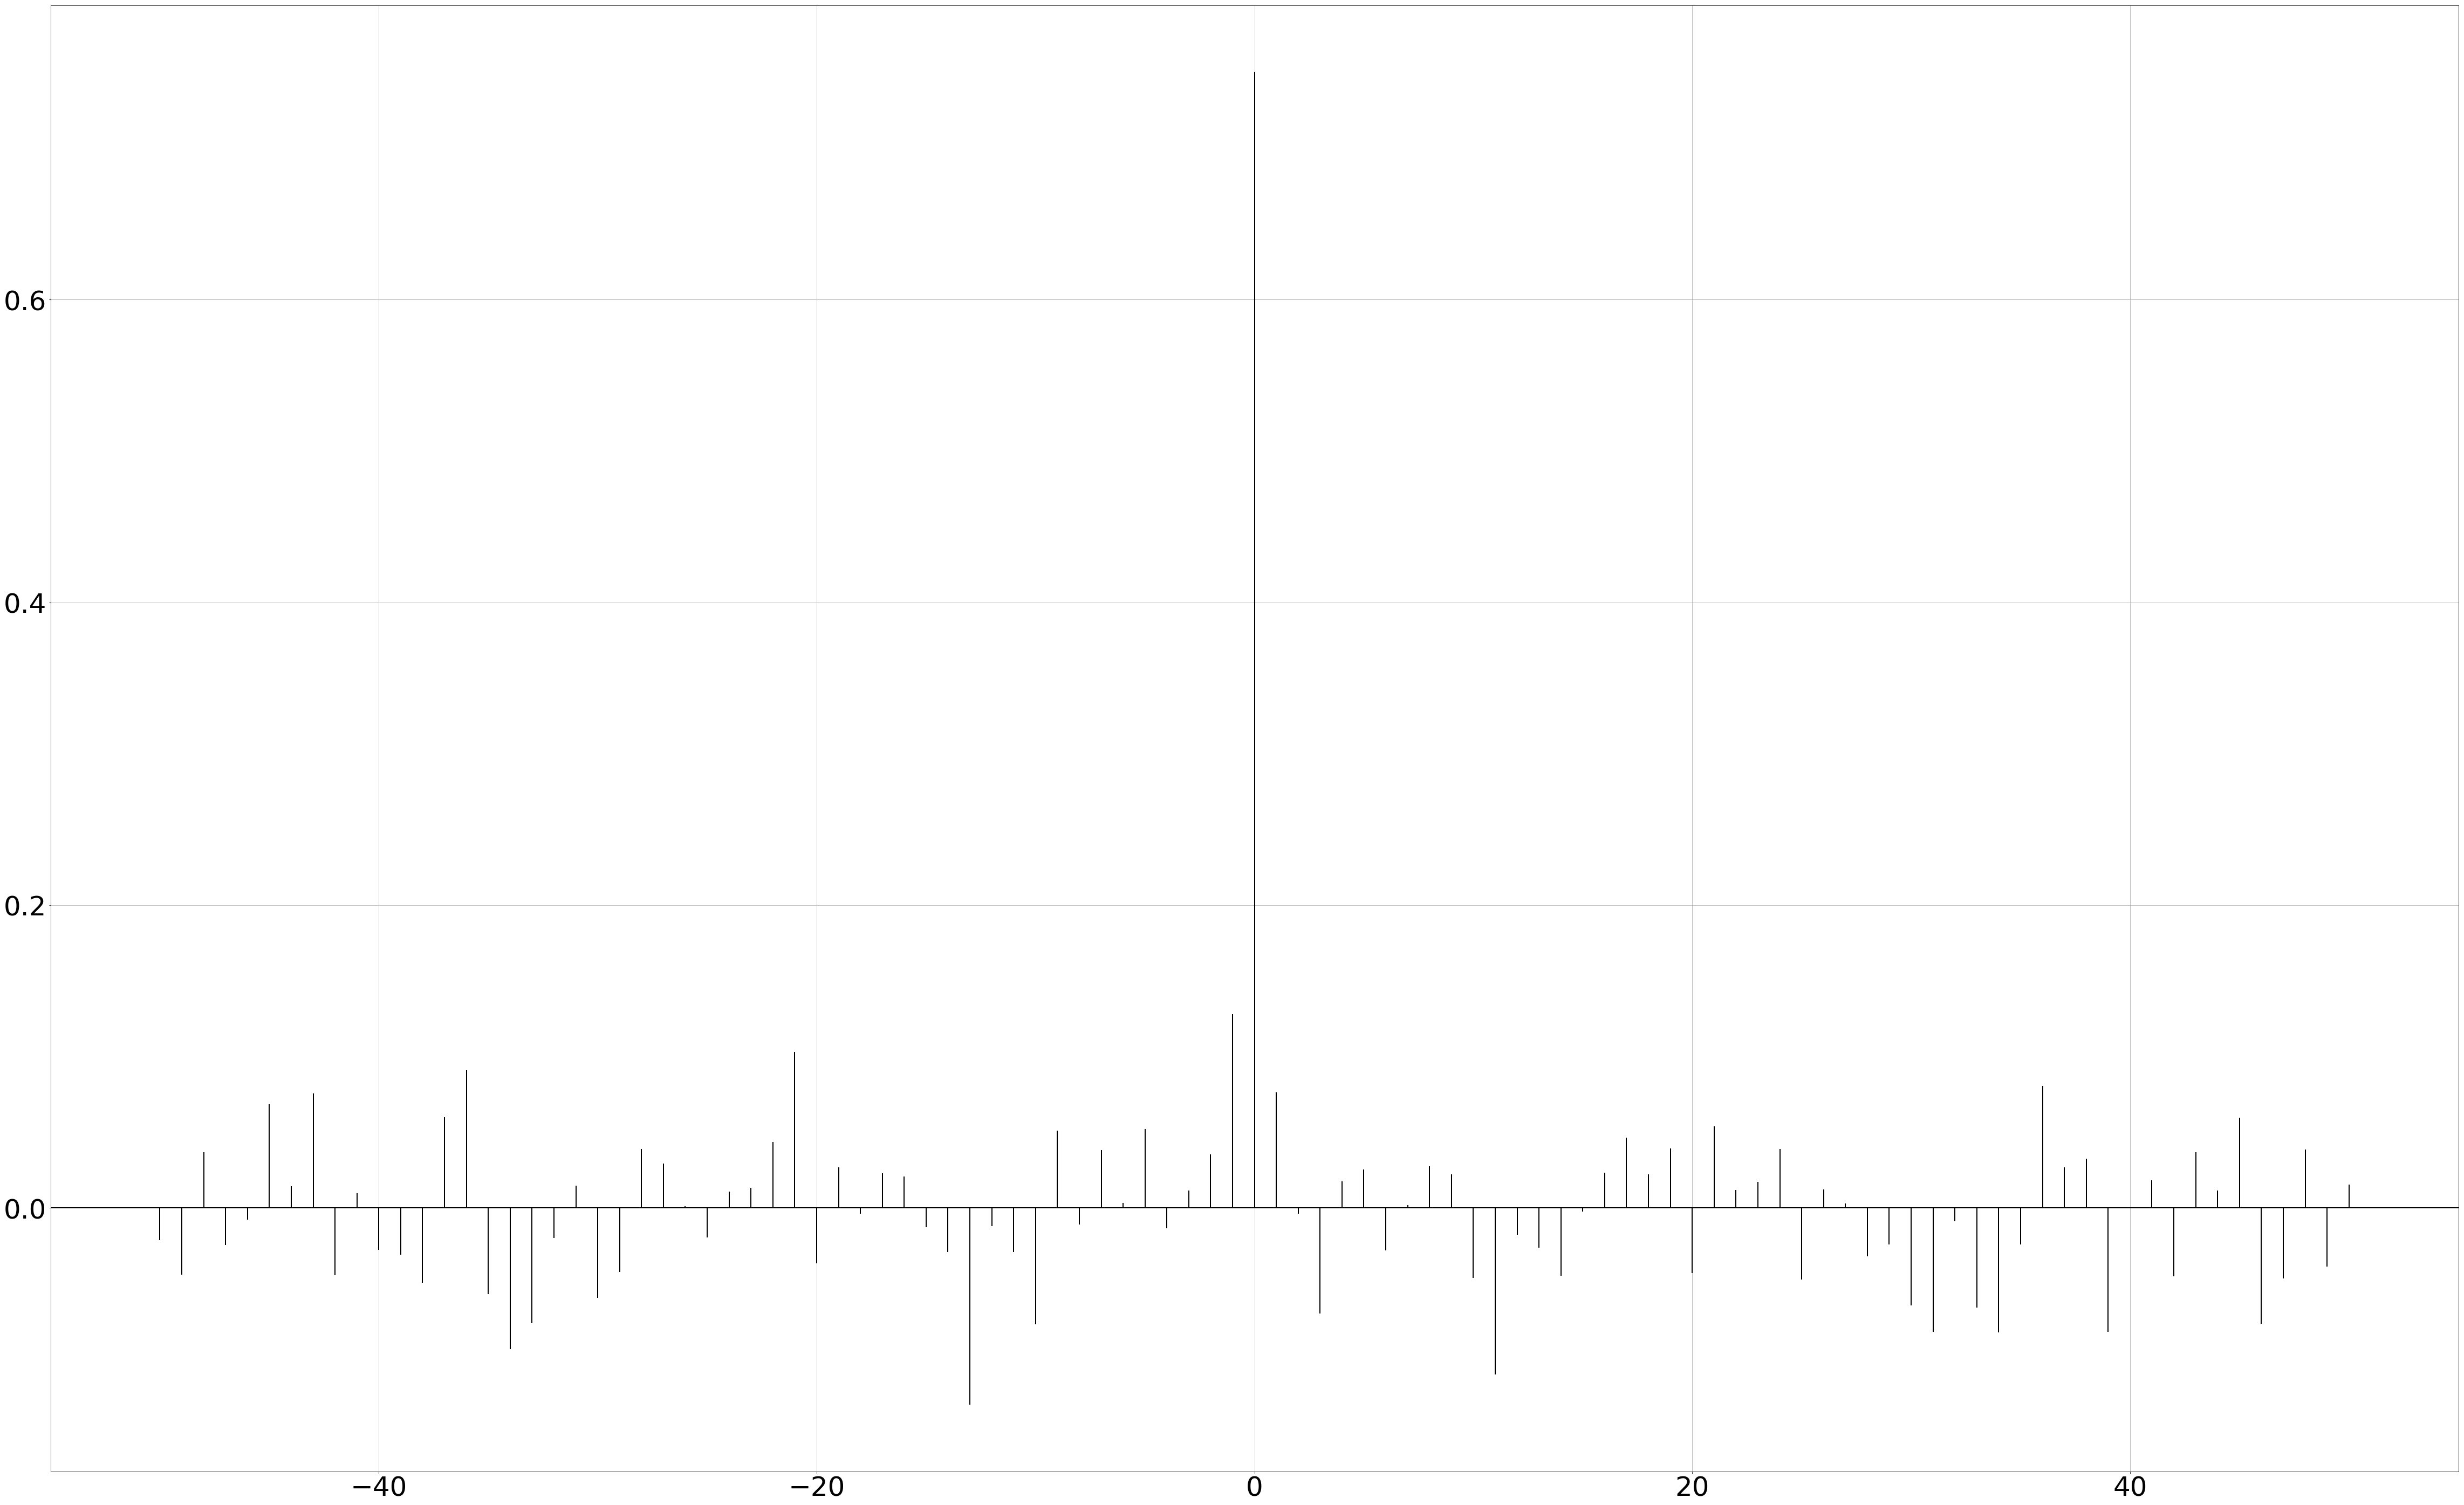

In [204]:
dataframe = dataframe.dropna()
plt.xcorr(dataframe['5m_return'][-500:].values, dataframe['5m_return1'][-500:].values, usevlines=True, maxlags=50, normed=True, lw=2)
plt.grid(True)
plt.axhline(0, color='black', lw=2)
plt.show()